# End to End Matching Example

Please run [Record-Linkage-Example.ipynb](Record-Linkage-Example.ipynb) before this one in order to get the trained model at `../trained-models/notebooks/rl/rl-model.ckpt`.

## Boilerplate

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

In [3]:
import sys

sys.path.insert(0, '..')

In [4]:
import entity_embed

In [5]:
import torch
import numpy as np

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

## Loading Test Data

In [6]:
import json
from ordered_set import OrderedSet

def load_pair_set(filepath):
    with open(filepath, 'r') as f:
        test_pos_pair_set = json.load(f)
        return OrderedSet(tuple(pair) for pair in test_pos_pair_set)

train_pos_pair_set = load_pair_set('../trained-models/notebooks/rl/rl-train-pos-pairs.json')
valid_pos_pair_set = load_pair_set('../trained-models/notebooks/rl/rl-valid-pos-pairs.json')
test_pos_pair_set = load_pair_set('../trained-models/notebooks/rl/rl-test-pos-pairs.json')

In [7]:
import json

def load_record_dict(filepath):
    with open(filepath, 'r') as f:
        record_dict = json.load(f)
        return {int(id_): record for id_, record in record_dict.items()}

train_record_dict = load_record_dict('../trained-models/notebooks/rl/rl-train-records.json')
valid_record_dict = load_record_dict('../trained-models/notebooks/rl/rl-valid-records.json')
test_record_dict = load_record_dict('../trained-models/notebooks/rl/rl-test-records.json')

## Loading Model

In [8]:
from entity_embed import LinkageEmbed

model = LinkageEmbed.load_from_checkpoint('../trained-models/notebooks/rl/rl-model.ckpt')

## Blocking

Use `sim_threshold = 0.45` to have ~6k pairs in `train_found_pair_set` and have a fair comparison with [End-to-End-Matching-Baseline.ipynb](./End-to-End-Matching-Baseline.ipynb)

In [9]:
%%time

eval_batch_size = 64
ann_k = 100
sim_threshold = 0.45

train_found_pair_set, train_vector_dict = model.predict_pairs(
    record_dict=train_record_dict,
    batch_size=eval_batch_size,
    ann_k=ann_k,
    sim_threshold=sim_threshold,
    show_progress=True,
    return_vector_dict=True
)

# batch embedding:   0%|          | 0/44 [00:00<?, ?it/s]

CPU times: user 28.5 s, sys: 846 ms, total: 29.4 s
Wall time: 5.21 s


In [10]:
%%time

valid_found_pair_set, valid_vector_dict = model.predict_pairs(
    record_dict=valid_record_dict,
    batch_size=eval_batch_size,
    ann_k=ann_k,
    sim_threshold=sim_threshold,
    show_progress=True,
    return_vector_dict=True
)

# batch embedding:   0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 9.68 s, sys: 310 ms, total: 9.99 s
Wall time: 1.92 s


In [11]:
%%time

test_found_pair_set, test_vector_dict = model.predict_pairs(
    record_dict=test_record_dict,
    batch_size=eval_batch_size,
    ann_k=ann_k,
    sim_threshold=sim_threshold,
    show_progress=True,
    return_vector_dict=True
)

# batch embedding:   0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 8.04 s, sys: 417 ms, total: 8.46 s
Wall time: 1.73 s


In [12]:
from entity_embed.evaluation import pair_entity_ratio

pair_entity_ratio(len(test_found_pair_set), len(test_record_dict))

0.9008810572687225

In [13]:
from entity_embed.evaluation import precision_and_recall

precision_and_recall(test_found_pair_set, test_pos_pair_set)

(0.2995110024449878, 0.98)

Complement the train/valid `found_pair_set` with `pos_pair_set` for training.  
Leave test untoched, to reproduce production behavior:

In [14]:
train_found_pair_set |= train_pos_pair_set
valid_found_pair_set |= valid_pos_pair_set

## Matching: Compare

Make a dataframe `df` with all records (train, valid, test) to add additional features:

In [15]:
record_dict = {**train_record_dict, **valid_record_dict, **test_record_dict}

In [16]:
import pandas as pd

df = pd.DataFrame.from_dict(record_dict, orient='index')
df = df.drop(columns='id')

In [17]:
df['all'] = df.agg('{0[title]} - {0[description]} - {0[manufacturer]} - {0[price]}'.format, axis=1)
df['price'] = pd.to_numeric(df['price'].str.replace(' ', ''), errors='coerce')
df.head(3)

,description,manufacturer,price,title,__source,cluster,all
1728,system requirements macintosh macintosh comput...,,1149.00,filemaker pro 8 . 5 5 - user pack,google,1561,filemaker pro 8 . 5 5 - user pack - system req...
255,- marketing information: diskeeper pro premier...,diskeeper corporation,736.66,diskeeper 2007 pro premier 5 - lic pack,amazon,1207,diskeeper 2007 pro premier 5 - lic pack - - ma...
2889,,,16.00,emc securid appl mnt - ent / std 17mo per u 2k...,google,2231,emc securid appl mnt - ent / std 17mo per u 2k...


Replace all `record_dict`s (train, valid, test) to add additional features:

In [18]:
train_record_dict = df.loc[train_record_dict.keys()].to_dict(orient='index')
valid_record_dict = df.loc[valid_record_dict.keys()].to_dict(orient='index')
test_record_dict = df.loc[test_record_dict.keys()].to_dict(orient='index')

del df

In [19]:
import textdistance as td
import math

def token_ops(func):
    def new_func(x, y):
        return func(x.split(), y.split())    
    return new_func

def empty_str(x, y):
    return int(not x or not y)

def empty_num(x, y):
    return int(not x or not y or math.isnan(x) or math.isnan(y))

def zero_if_empty(x):
    if not x or math.isnan(x):
        return 0
    else:
        return x

def abs_diff(x, y):
    return abs(zero_if_empty(x) - zero_if_empty(y))

def abs_diff_log10(x, y, min_val=math.log10(1e-5)):
    diff = abs_diff(x, y)
    if diff > 0:
        return max(math.log10(diff), min_val)
    else:
        return min_val

SIM_FUNC_DICT = {
    ("all", "jaccard"): token_ops(td.jaccard.normalized_similarity),
    ("all", "overlap"): token_ops(td.overlap.normalized_similarity),
    ("all", "damerau_levenshtein"): td.damerau_levenshtein.normalized_similarity,
    ("all", "jaro_winkler"): td.jaro_winkler.normalized_similarity,
    ("manufacturer", "empty_str"): empty_str,
    ("manufacturer", "jaccard"): token_ops(td.jaccard.normalized_similarity),
    ("manufacturer", "overlap"): token_ops(td.overlap.normalized_similarity),
    ("manufacturer", "damerau_levenshtein"): td.damerau_levenshtein.normalized_similarity,
    ("manufacturer", "jaro_winkler"): td.jaro_winkler.normalized_similarity,
    ("title", "jaccard"): token_ops(td.jaccard.normalized_similarity),
    ("title", "overlap"): token_ops(td.overlap.normalized_similarity),
    ("title", "damerau_levenshtein"): td.damerau_levenshtein.normalized_similarity,
    ("title", "jaro_winkler"): td.jaro_winkler.normalized_similarity,
    ("price", "empty_num"): empty_num,
    ("price", "abs_diff"): abs_diff,
    ("price", "abs_diff_log10"): abs_diff_log10,
}

def record_sim_func(record_pair):
    record_left, record_right = record_pair
    feature_dict = {}
    
    for (field, sim_func_name), sim_func in SIM_FUNC_DICT.items():
        sim = sim_func(record_left[field], record_right[field])
        feature_dict[f"{field}_{sim_func_name}"] = sim
    
    return feature_dict

In [20]:
%%time

pair = next(iter(test_pos_pair_set))
id_left, id_right = pair
feature_dict = record_sim_func((test_record_dict[id_left], test_record_dict[id_right]))

# display(test_record_dict[id_left], test_record_dict[id_right])
feature_dict

CPU times: user 2.57 ms, sys: 0 ns, total: 2.57 ms
Wall time: 2.35 ms


{'all_jaccard': 0.0757575757575758,
 'all_overlap': 0.6896551724137931,
 'all_damerau_levenshtein': 0.09502262443438914,
 'all_jaro_winkler': 0.545101848989317,
 'manufacturer_empty_str': 1,
 'manufacturer_jaccard': 0.0,
 'manufacturer_overlap': 0.0,
 'manufacturer_damerau_levenshtein': 0.0,
 'manufacturer_jaro_winkler': 0.0,
 'title_jaccard': 0.7142857142857143,
 'title_overlap': 1.0,
 'title_damerau_levenshtein': 0.8888888888888888,
 'title_jaro_winkler': 0.9652777777777778,
 'price_empty_num': 0,
 'price_abs_diff': 14.709999999999994,
 'price_abs_diff_log10': 1.16761267272753}

In [21]:
from collections import defaultdict
import multiprocessing
from tqdm.auto import tqdm

def compare_pairs(record_dict, found_pair_set):
    all_feature_dict = defaultdict(list)
    chunksize = 100
    tasks = (
        (record_dict[id_left], record_dict[id_right])
        for (id_left, id_right)
        in found_pair_set
    )

    with multiprocessing.Pool() as pool:
        for feature_dict in tqdm(
            pool.imap(record_sim_func, tasks, chunksize=chunksize),
            total=len(found_pair_set)
        ):
            for feature, val in feature_dict.items():
                all_feature_dict[feature].append(val)

        pool.close()
        pool.join()
    
    return pd.DataFrame(all_feature_dict, index=pd.MultiIndex.from_tuples(found_pair_set))

In [22]:
%%time

train_feature_df = compare_pairs(train_record_dict, train_found_pair_set)
assert len(train_feature_df) == len(train_found_pair_set)
len(train_found_pair_set)

  0%|          | 0/6118 [00:00<?, ?it/s]

CPU times: user 533 ms, sys: 162 ms, total: 695 ms
Wall time: 4.63 s


6118

In [23]:
%%time

valid_feature_df = compare_pairs(valid_record_dict, valid_found_pair_set)
assert len(valid_feature_df) == len(valid_found_pair_set)
len(valid_found_pair_set)

  0%|          | 0/829 [00:00<?, ?it/s]

CPU times: user 49.7 ms, sys: 96.7 ms, total: 146 ms
Wall time: 831 ms


829

In [24]:
%%time

test_feature_df = compare_pairs(test_record_dict, test_found_pair_set)
assert len(test_feature_df) == len(test_found_pair_set)
len(test_found_pair_set)

  0%|          | 0/818 [00:00<?, ?it/s]

CPU times: user 62.9 ms, sys: 96.8 ms, total: 160 ms
Wall time: 948 ms


818

## Matching: Compare - TFIDF Feature

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_tfidf_vectorizer(train_record_dict, valid_record_dict, field='all'):
    tfidf_vectorizer = TfidfVectorizer(
        analyzer='char',
        ngram_range=(2,4),
        min_df=2
    )
    train_valid_record_dict = {**train_record_dict, **valid_record_dict}
    tfidf_vectorizer.fit(record[field] for record in train_valid_record_dict.values())
    return tfidf_vectorizer

tfidf_vectorizer = get_tfidf_vectorizer(train_record_dict, valid_record_dict)
tfidf_vectorizer

TfidfVectorizer(analyzer='char', min_df=2, ngram_range=(2, 4))

In [26]:
import numpy as np

def add_tfidf_feature(tfidf_vectorizer, feature_df, record_dict, found_pair_set, field='all'):
    tfidf_matrix = tfidf_vectorizer.transform(record[field] for record in record_dict.values())

    id_to_idx = {id_: idx for idx, id_ in enumerate(record_dict.keys())}
    left_idx = [id_to_idx[left_id] for left_id, __ in found_pair_set]
    right_idx = [id_to_idx[right_id] for __, right_id in found_pair_set]
    tfidf_sim = tfidf_matrix[left_idx].multiply(tfidf_matrix[right_idx]).sum(axis=1)

    feature_df[f'{field}_tfidf'] = tfidf_sim

In [27]:
%%time

add_tfidf_feature(tfidf_vectorizer, train_feature_df, train_record_dict, train_found_pair_set)

CPU times: user 1.69 s, sys: 23.7 ms, total: 1.72 s
Wall time: 1.72 s


In [28]:
%%time

add_tfidf_feature(tfidf_vectorizer, valid_feature_df, valid_record_dict, valid_found_pair_set)

CPU times: user 567 ms, sys: 3.85 ms, total: 571 ms
Wall time: 571 ms


In [29]:
%%time

add_tfidf_feature(tfidf_vectorizer, test_feature_df, test_record_dict, test_found_pair_set)

CPU times: user 558 ms, sys: 8.03 ms, total: 566 ms
Wall time: 565 ms


## Matching: Compare - Embedding Cosine Feature 

In [30]:
import numpy as np

def add_embed_cos_feature(feature_df, vector_dict, found_pair_set):
    id_to_idx = {id_: idx for idx, id_ in enumerate(vector_dict.keys())}
    embed_matrix = np.stack(list(vector_dict.values()))
    left_idx = [id_to_idx[left_id] for left_id, __ in found_pair_set]
    right_idx = [id_to_idx[right_id] for __, right_id in found_pair_set]
    sim = np.multiply(embed_matrix[left_idx], embed_matrix[right_idx]).sum(axis=1)
    feature_df['embed_cos'] = sim

In [31]:
%%time

add_embed_cos_feature(train_feature_df, train_vector_dict, train_found_pair_set)

CPU times: user 3.63 ms, sys: 7.99 ms, total: 11.6 ms
Wall time: 11.4 ms


In [32]:
%%time

add_embed_cos_feature(valid_feature_df, valid_vector_dict, valid_found_pair_set)

CPU times: user 2.61 ms, sys: 0 ns, total: 2.61 ms
Wall time: 2.34 ms


In [33]:
%%time

add_embed_cos_feature(test_feature_df, test_vector_dict, test_found_pair_set)

CPU times: user 2.55 ms, sys: 0 ns, total: 2.55 ms
Wall time: 2.31 ms


## Matching: Classify

In [34]:
train_valid_feature_df = pd.concat([train_feature_df, valid_feature_df])
train_valid_feature_df.head(3)

,,all_jaccard,all_overlap,all_damerau_levenshtein,all_jaro_winkler,manufacturer_empty_str,manufacturer_jaccard,manufacturer_overlap,manufacturer_damerau_levenshtein,manufacturer_jaro_winkler,title_jaccard,title_overlap,title_damerau_levenshtein,title_jaro_winkler,price_empty_num,price_abs_diff,price_abs_diff_log10,all_tfidf,embed_cos
272,3735,0.187135,0.561404,0.254545,0.638474,1,0.0,0.0,0.0,0.0,0.454545,1.000000,0.277778,0.855556,0,0.05,-1.301030,0.543742,0.945604
938,2238,0.122340,0.442308,0.224708,0.591965,1,0.0,0.0,0.0,0.0,0.230769,0.428571,0.351852,0.696147,0,3.15,0.498311,0.543040,0.915240
352,4234,0.357143,0.555556,0.372340,0.760573,1,0.0,0.0,0.0,0.0,0.400000,0.666667,0.375000,0.719444,0,0.00,-5.000000,0.442623,0.916960


In [35]:
train_true_y = np.array([pair in train_pos_pair_set for pair in train_found_pair_set], dtype='i4')
valid_true_y = np.array([pair in valid_pos_pair_set for pair in valid_found_pair_set], dtype='i4')
test_true_y = np.array([pair in test_pos_pair_set for pair in test_found_pair_set], dtype='i4')

In [36]:
train_valid_true_y = np.concatenate([train_true_y, valid_true_y])

In [37]:
%%time

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=random_seed)
clf.fit(train_valid_feature_df, train_valid_true_y)

CPU times: user 1.51 s, sys: 23.4 ms, total: 1.53 s
Wall time: 315 ms


RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42)

In [38]:
clf.oob_score_

0.9275946451705772

In [39]:
feature_importances = dict(zip(train_valid_feature_df.columns, clf.feature_importances_))
sorted(feature_importances.items(), key=lambda kv: kv[1], reverse=True)

[('embed_cos', 0.33697342248373824),
 ('title_overlap', 0.12276315077103618),
 ('title_jaccard', 0.07231144875654234),
 ('all_tfidf', 0.06629056263794562),
 ('price_abs_diff', 0.05987689471651935),
 ('title_damerau_levenshtein', 0.054893705699185016),
 ('price_abs_diff_log10', 0.052170044764016675),
 ('all_overlap', 0.04687039175417089),
 ('title_jaro_winkler', 0.046699983740381715),
 ('all_jaccard', 0.04652771482639955),
 ('all_jaro_winkler', 0.03824354799951319),
 ('all_damerau_levenshtein', 0.03608902687046782),
 ('manufacturer_jaro_winkler', 0.004718749159100829),
 ('manufacturer_damerau_levenshtein', 0.004709856669781965),
 ('price_empty_num', 0.0038658262353301154),
 ('manufacturer_jaccard', 0.0035201897713516435),
 ('manufacturer_overlap', 0.0017738086398652198),
 ('manufacturer_empty_str', 0.0017016745046536607)]

In [40]:
from sklearn.metrics import accuracy_score

cls_threshold = 0.3
train_valid_pred_y = clf.predict_proba(train_valid_feature_df)
train_valid_pred_y[train_valid_pred_y >= cls_threshold] = 1
train_valid_pred_y[train_valid_pred_y < cls_threshold] = 0
train_valid_pred_y = train_valid_pred_y[:, 1]
accuracy_score(train_valid_pred_y, train_valid_true_y)

0.992658701597812

In [41]:
from sklearn.metrics import precision_recall_fscore_support

pred_y = clf.predict_proba(test_feature_df)
pred_y[pred_y >= cls_threshold] = 1
pred_y[pred_y < cls_threshold] = 0
pred_y = pred_y[:, 1]
precision_recall_fscore_support(test_true_y, pred_y, labels=[1])

(array([0.77489177]), array([0.73061224]), array([0.75210084]), array([245]))

In [42]:
cls_found_pair_set = OrderedSet(test_feature_df[pred_y.astype(bool)].index)

precision_and_recall(cls_found_pair_set, test_pos_pair_set)

(0.7748917748917749, 0.716)

False negatives:

In [43]:
for x, y in list(test_pos_pair_set - cls_found_pair_set)[:10]:
    display(((x, y), test_record_dict[x]['title'], test_record_dict[y]['title']))

((774, 1730),
 'adobe software acrobat pro upgrd pro - pro mac ( adbcd01798mc )',
 'adobe acrobat v8 . 0 professional for mac upgrade')

((990, 3606),
 'power production storyboard artist 4',
 'power production power production storyboard artist software animation software')

((598, 2318),
 'adobe pagemaker v7 . 0 . 2 cd mac - upg ( 17530402 )',
 'adobe pagemaker 7 . 0 for mac version upgrade')

((312, 1940),
 'norton antivirus 2007',
 'symantec norton anti - virus 2007 windows')

((644, 1693),
 'microspot macdraft pe ( mac )',
 'microspot macdraft pe personal edition')

((50, 3453),
 'clifford the big red dog - thinking adventures',
 'clifford thinking')

((97, 3000),
 'tournament poker 2005',
 "eagle games egl 150 tournament poker - no limit texas hold ' em")

((199, 1428),
 'netmanage upg rumba unix - hp edition level ( 902453 - 007 - c )',
 '902453 - 007 - b rumba unix - hp edition - upgrade license - 1 user - volume - level b ( 5 - 49 ) - c')

((243, 1504),
 'money premium 2007 win32 eng na mini box us only cd',
 'money prem 2007 cd minibox')

((1350, 1958), 'train sim modeler design studio', 'abacus train sim modeler')

In [47]:
pair = (644, 1693)
display(test_feature_df.loc[[pair]])
clf.predict_proba(test_feature_df.loc[[pair]])

,,all_jaccard,all_overlap,all_damerau_levenshtein,all_jaro_winkler,manufacturer_empty_str,manufacturer_jaccard,manufacturer_overlap,manufacturer_damerau_levenshtein,manufacturer_jaro_winkler,title_jaccard,title_overlap,title_damerau_levenshtein,title_jaro_winkler,price_empty_num,price_abs_diff,price_abs_diff_log10,all_tfidf,embed_cos
644,1693,0.125,0.292683,0.307506,0.648112,1,0.0,0.0,0.0,0.0,0.375,0.6,0.631579,0.8835,0,13.96,1.144885,0.272008,0.719391


array([[1., 0.]])

<Figure size 1152x720 with 0 Axes>

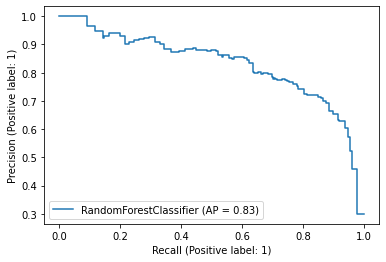

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score

plt.figure(figsize=(16,10))

disp = plot_precision_recall_curve(clf, test_feature_df, test_true_y)